# IME pilot intron individual reporters, qPCR + FACS analysis

In [1]:
from datetime import date
print('created 2018-01-06')
print("last updated", date.today())

created 2018-01-06
last updated 2025-01-23


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import csv
import pygments
import itertools
pd.set_option('mode.chained_assignment',None)
%matplotlib inline

In [3]:
# aesthetics
def prettify_ax(ax):
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

# pretty colours
An_subset_colors = [(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522)]

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'medium')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight = 'medium')  # fontsize of the figure title

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi']= 300

#plt.rc('ticklabel_format', axis='y', style='sci', scilimits=(0,3))

# preprocessing functions

In [4]:
#################################################################
#################################################################

# load qPCR table with first row = header, columns 
# Sample (of the form "cell pEK#")
# Primers
# Rep
# and all NaN Cp values entered as 40
def load_qPCR(filename):
    df = pd.read_csv('/Users/emmakowal/Dropbox (MIT)/Lab/qPCR/%s' % filename, sep=',', header=0)
    df.dropna(inplace=True)
    return df

def load_FACS(month,filename):
    FACS = pd.read_csv('/Users/emmakowal/Dropbox (MIT)/Lab/FACS/%s/%s' % (month,filename), sep='\t')
    FACS = pd.concat([FACS]*2,ignore_index=True)
    FACS['Fluor'] = ['GFP']*int(len(FACS)/2) + ['dTomato']*int(len(FACS)/2)
    FACS['GeoMean'] = FACS['Geometric Mean (FITC-A)']
    FACS['GeoMean'][FACS.Fluor=="dTom"] = FACS['Geometric Mean (PE-A)']
    FACS['GeoMean'][FACS.Fluor=="dTomato"] = FACS['Geometric Mean (PE-A)']
    FACS['CV'] = FACS['CV (FITC-A)']
    FACS['CV'][(FACS.Fluor=="dTom")] = FACS['CV (PE-A)']
    FACS['CV'][(FACS.Fluor=="dTomato")] = FACS['CV (PE-A)']
    samplescolumn = FACS.iloc[:,0]
    FACS = FACS.iloc[:,5:8]
    FACS.columns = ['Fluor',"GeoMean","CV"]
    FACS['Sample'] = samplescolumn
    FACS = FACS[FACS.Sample.str.contains('Specimen')]
    FACS.Sample = [str.split(x,'_')[2] for x in FACS.Sample]
    FACS["Cell"] = [str.split(x,'-')[0] for x in FACS.Sample]
    FACS["Cell"][FACS.Cell=="HELA"] = "HeLa"
    FACS['Promoter'] = list(samples_key.promoter[[str.split(x,'-')[1] for x in FACS.Sample]])
    FACS['Intron'] = list(samples_key.intron[[str.split(x,'-')[1] for x in FACS.Sample]])
    FACS['Day'] = 1
    return FACS 

def load_mult_FACS(month1,filename1,month2,filename2):
    FACS1 = load_FACS(month1,filename1)
    FACS2 = load_FACS(month2,filename2)
    FACS2["Day"] = 2
    FACS = pd.concat([FACS1,FACS2])
    FACS.index=np.arange(len(FACS))
    return FACS

#################################################################
#################################################################

# scatter raw Cp values, grouped by sample and colored by primers
def CpScatter(df,sample_names,primer_names,pdf=False,colors=An_subset_colors,wiggle=True,
             filename='Figure',title="Raw Cp Values",leg=1):

    N=len(sample_names)
    ind = np.arange(N)    # x axis positions for the sample names
    qPCR = df[df.Sample.isin(sample_names)&df.Primers.isin(primer_names)] 
    # subset data to particular samples if necessary
    primers = [primer_names.index(n) for n in qPCR.Primers] # to color points by primers
    x = [sample_names.index(n) for n in qPCR.Sample]
    x = [num+1 for num in x] # x axis positions for data
    
    if wiggle:
        x = x + np.random.normal(0, 0.05, len(x)) # scatter points slightly for visualization

    if pdf:
        pp = PdfPages('%s.pdf' % filename) # save figure as pdf
    
    # make figure
    fig, ax = simple_ax(figsize=(N+1,6))
    ax.scatter(x, qPCR.Cp, c = primers, 
               cmap=mpl.colors.ListedColormap(colors),
               s=60, alpha=1, edgecolor='w', marker='o')
    ax.set_title(title, fontsize=12)

    # set labels
    ax.set_xticks(ind+1)
    ax.set_xticklabels(sample_names, rotation=30, fontsize=12)
    ax.set_ylabel('Cp', fontsize=12)

    # set limits
    ymax = (max(qPCR.Cp)+2)-(max(qPCR.Cp)+2)%2
    ymin = (min(qPCR.Cp)-2)-(min(qPCR.Cp)-2)%2
    ax.set_ylim([ymax,ymin])
    ax.set_yticks(np.arange(ymin,ymax+2,2))
    ax.set_xlim([0,(N+1)])

    # make legend
    patches = []
    for i in range(len(primer_names)):
        patches.append(mpatches.Patch(color=colors[i], label=primer_names[i]))
        plt.legend(handles=patches, loc=leg, fontsize=12)

    if pdf:
        pp.savefig(bbox_inches="tight")
        pp.close()
    
    plt.show()
    
#################################################################
#################################################################

# take median Cp value of technical replicates
def techReps(df,samples,primers,reps):
    
    df2 = df.copy()
    
    for sample in samples:
        for primer in primers:
            for rep in [x+1 for x in range(reps)]:
                df2.drop(df2.Cp[(df2.Sample == sample) & 
                                (df2.Primers == primer) & 
                                (df2.Rep == rep)].idxmax(), inplace=True)
                df2.drop(df2.Cp[(df2.Sample == sample) & 
                                (df2.Primers == primer) &
                                (df2.Rep == rep)].idxmin(),inplace=True)
    return df2

#################################################################
#################################################################

# take average Cp value of technical replicates
def techRepsAvg(df,samples,primers,reps):
    sample_num = len(samples)*len(primers)
    new_df = pd.DataFrame(columns=['Sample','Primers','Cp'],
                          index=np.arange(sample_num))
    n=0
    for sample in samples:
        for primer in primers:
            new_df.loc[n,'Sample'] = sample
            new_df.loc[n,'Primers'] = primer
            new_df.loc[n,'Cp'] = np.mean(df.Cp[(df.Sample==sample)&(df.Primers==primer)])
            n+=1
    return new_df

#################################################################
#################################################################

# take average Cp value of technical replicates in preprocessed table
def techRepsAvg_proc(df,samples,primers,reps):
    sample_num = len(samples)*len(primers)*reps
    new_df = pd.DataFrame(columns=['Sample','Primers','Cp'],
                          index=np.arange(sample_num))
    n=0
    for sample in samples:
        for primer in primers:
            for rep in list(np.arange(reps)+1):
                new_df.loc[n,'Sample'] = sample
                new_df.loc[n,'Primers'] = primer
                new_df.loc[n,'Rep'] = rep
                new_df.loc[n,'Cell'] = str(list(df.Cell[(df.Sample==sample)&(df.Primers==primer)&(df.Rep==rep)])[0])
                new_df.loc[n,'Promoter'] = list(df.Promoter[(df.Sample==sample)&(df.Primers==primer)
                                             &(df.Rep==rep)])[0]
                new_df.loc[n,'Intron'] = list(df.Intron[(df.Sample==sample)&(df.Primers==primer)
                                             &(df.Rep==rep)])[0]
                new_df.loc[n,'Cp'] = np.mean(df.Cp[(df.Sample==sample)&(df.Primers==primer)
                                                 &(df.Rep==rep)])
                n+=1
    return new_df

#################################################################
#################################################################

# process df for ease of plotting
# i.e. split sample names into columns of cell type, promoter, intron/no intron
def process_samples(df_raw,cells,promoters,promoter_samples,intron_samples):
    df = df_raw.copy()
    df["Cell"] = ""
    for i in range(len(cells)):
        df.Cell[df.Sample.str.contains(cells[i])] = cells[i]
#pEK25_2FCs.Sample = [x.replace('293 ', '').replace('HeLa ', '') for x in pEK25_2FCs.Sample]
    df["Intron"] = False
    for i in range(len(intron_samples)):
        df.Intron[df.Sample.str.contains(intron_samples[i])] = True
    df["Promoter"] = ""
    for i in range(len(promoter_samples)):
        df.Promoter[df.Sample.str.contains(promoter_samples[i])] = promoters[i]
    return df
        
#process_samples(pEK25_2FCs,['HeLa',"293"],['UbC','UbC','UbC','EF1a','EF1a'],
#                ['pEK2','pEK3-','pEK3+','pEK5','pEK4'],['pEK2','pEK4'])

#################################################################
#################################################################

# compute ∆∆Ct by bio rep for each intron/∆intron pair
# where data has already been filtered to median of tech reps
# and preprocessed with process_samples

def ddCt(df,sample_names,primer_names,reps,control):
    sample_num = len(primer_names)*max(df.Rep)*len(set(df.Promoter))*len(set(df.Cell))
    
    ddCt_df = pd.DataFrame(columns=['Promoter','Cell','Primers','Rep','FC'],
                          index=np.arange(sample_num))

    # compute ∆∆Ct using control as housekeeping gene and intron T/F as condition
    
    n=0
    
    for i in df.index[(df.Primers.isin(primer_names))&
                     (df.Intron)]:
        test_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                         (df.Primers == df.Primers[i]) & 
                         (df.Cell == df.Cell[i])&
                         (df.Rep == df.Rep[i])&
                         (df.Intron)]
        test_no_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                         (df.Primers == df.Primers[i]) &
                         (df.Cell == df.Cell[i])&
                         (df.Rep == df.Rep[i])&
                         (df.Intron==False)]
        ctrl_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                         (df.Primers == control) & 
                         (df.Cell == df.Cell[i])&
                         (df.Rep == df.Rep[i])&
                         (df.Intron)]
        ctrl_no_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                         (df.Primers == control) & 
                         (df.Cell == df.Cell[i])&
                         (df.Rep == df.Rep[i])&
                         (df.Intron==False)]
        
        no_int = float(test_no_int)-float(ctrl_no_int)
        w_int = float(test_int)-float(ctrl_int)
        
        ddCt_df.loc[n,'Rep'] = df.Rep[i]
        ddCt_df.loc[n,'Primers'] = df.Primers[i]
        ddCt_df.loc[n,'Cell'] = df.Cell[i]
        ddCt_df.loc[n,'Promoter'] = df.Promoter[i]
        ddCt_df.loc[n,'FC'] = 2.**(no_int-w_int)
        n+=1     
    print(sample_num)
    return ddCt_df

#################################################################
#################################################################

# compute ∆∆Ct by bio rep for each intron/∆intron pair
# where data CONTAINS MULTIPLE INTRONS
# and has already been filtered to median of tech reps
# and preprocessed with process_samples

def ddCt2(df,sample_names,primer_names,intron_names,reps,control):
    sample_num = len(primer_names)*max(df.Rep)*len(set(df.Cell))*(len(set(df.Sample))-(len(set(df.Promoter))))
    
    ddCt_df = pd.DataFrame(columns=['Promoter','Intron','Cell','Primers','Rep','FC'],
                          index=np.arange(sample_num))

    # compute ∆∆Ct using control as housekeeping gene and intron as condition
    
    n=0
    for i in df.index[(df.Primers.isin(primer_names))&
                      (df.Sample.isin(sample_names))&
                      (df.Intron != 'none')]:
            test_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                             (df.Primers == df.Primers[i]) & 
                             (df.Cell == df.Cell[i])&
                             (df.Rep == df.Rep[i])&
                             (df.Intron == df.Intron[i])]
            test_no_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                             (df.Primers == df.Primers[i]) &
                             (df.Cell == df.Cell[i])&
                             (df.Rep == df.Rep[i])&
                             (df.Intron=='none')]
            ctrl_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                             (df.Primers == control) & 
                             (df.Cell == df.Cell[i])&
                             (df.Rep == df.Rep[i])&
                             (df.Intron == df.Intron[i])]
            ctrl_no_int = df.Cp[(df.Promoter == df.Promoter[i]) & 
                             (df.Primers == control) & 
                             (df.Cell == df.Cell[i])&
                             (df.Rep == df.Rep[i])&
                             (df.Intron=='none')]

            no_int = float(test_no_int)-float(ctrl_no_int)
            w_int = float(test_int)-float(ctrl_int)

            ddCt_df.loc[n,'Rep'] = df.Rep[i]
            ddCt_df.loc[n,'Intron'] = df.Intron[i]
            ddCt_df.loc[n,'Primers'] = df.Primers[i]
            ddCt_df.loc[n,'Cell'] = df.Cell[i]
            ddCt_df.loc[n,'Promoter'] = df.Promoter[i]
            ddCt_df.loc[n,'FC'] = 2.**(no_int-w_int)
            n+=1     
    return ddCt_df

#################################################################
#################################################################

# process qPCR df for ease of plotting
# i.e. split sample names into columns of cell type, promoter, intron
def process_qPCR(df_raw):
    df = df_raw.copy()
    df["Cell"] = [str.split(x,' ')[0] for x in df_raw.Sample]
    df["Intron"] = list(samples_key.intron[[str.split(x,' ')[1] for x in df_raw.Sample]])
    df["Promoter"] = list(samples_key.promoter[[str.split(x,' ')[1] for x in df_raw.Sample]])
    return df.loc[:,('Sample','Cell','Promoter','Intron','Rep','Primers','Cp')]

# process FACS df for plotting
# i.e. split sample names into columns of cell type, promoter, intron/no intron
def process_FACS(df_raw,cells,promoters,promoter_samples,intron_samples):
    df = df_raw.copy()
    df["Cell"] = "293"
    for i in range(len(cells)):
        df.Cell[df.Sample.str.contains(cells[i],case=False)] = cells[i]
    df["Intron"] = False
    for i in range(len(intron_samples)):
        df.Intron[df.Sample.str.contains(intron_samples[i])] = True
    df["Promoter"] = ""
    for i in range(len(promoter_samples)):
        df.Promoter[df.Sample.str.contains(promoter_samples[i])] = promoters[i]
    return df

#################################################################
#################################################################

# compute difference in median fluorescence

def dFluor3(df,intron_names):
    sample_num = len(intron_names)
    dFluor_df = pd.DataFrame(columns=['Promoter','Cell','Intron','Fluor','FC','CV'],
                          index=np.arange(sample_num))
    
    n=0
    
    for intron in intron_names:
        for i in df.index[(df.Intron==intron)]:
            baseline = float(np.mean(df.GeoMean[(df.Promoter == 'RMCE') & 
                                 (df.Fluor == df.Fluor[i]) &
                                 (df.Day == df.Day[i]) &
                                 (df.Cell == df.Cell[i])]))
            baselineCV = float(np.mean(df.CV[(df.Promoter == 'RMCE') & 
                                 (df.Fluor == df.Fluor[i]) &
                                 (df.Day == df.Day[i]) &
                                 (df.Cell == df.Cell[i])]))
            intronMean = float(df.GeoMean[i])
            intronCV = float(df.CV[i])
            no_intronMean = float(np.mean(df.GeoMean[(df.Promoter == df.Promoter[i]) & 
                             (df.Fluor == df.Fluor[i]) &
                             (df.Cell == df.Cell[i]) &
                             (df.Day == df.Day[i]) &
                             (df.Intron=='none')]))
            no_intronCV = float(np.mean(df.CV[(df.Promoter == df.Promoter[i]) & 
                             (df.Fluor == df.Fluor[i]) &
                             (df.Cell == df.Cell[i]) &
                             (df.Day == df.Day[i]) &
                             (df.Intron=='none')]))
            FC = float(intronMean/baseline)/float(no_intronMean/baseline)
            CV = float(intronCV/baselineCV)/float(no_intronCV/baselineCV)

            dFluor_df.loc[n,'Fluor'] = df.Fluor[i]
            dFluor_df.loc[n,'Cell'] = df.Cell[i]
            dFluor_df.loc[n,'Promoter'] = df.Promoter[i]
            dFluor_df.loc[n,'Intron'] = intron
            dFluor_df.loc[n,'FC'] = float(FC)
            dFluor_df.loc[n,'CV'] = float(CV)
            n+=1     
        
    return dFluor_df

#################################################################
#################################################################

def prepForPlot2(df_RNA,df_prot):
    
    sample_num = len(set(df_RNA.Primers))*len(set(df_RNA.Promoter))*len(set(df_RNA.Cell))*len(set(df_RNA.Intron))
    
    plot_df = pd.DataFrame(columns=['Promoter','Cell','Intron','Reporter',
                                    'meanRNA_FC','SDRNA_FC',
                                    'meanProt_FC','CVProt_FC'],
                          index=np.arange(sample_num))

    # compute mean and std of RNA FC from ddCt
    # grab med and std of prot FC from dFluor
    
    n=0
    
    for cell in set(df_RNA.Cell):
        for reporter in set(df_RNA.Primers):
            for promoter in set(df_RNA.Promoter):
                for intron in set(df_RNA.Intron):
                    RNA_mean = np.mean(df_RNA.FC[(df_RNA.Promoter==promoter)&
                                                (df_RNA.Cell==cell)&
                                                (df_RNA.Intron==intron)&
                                                (df_RNA.Primers==reporter)])
                    RNA_SD = np.std(df_RNA.FC[(df_RNA.Promoter==promoter)&
                                                (df_RNA.Cell==cell)&
                                                (df_RNA.Intron==intron)&
                                                (df_RNA.Primers==reporter)])
                    prot_mean = np.mean(df_prot.FC[(df_prot.Promoter==promoter)&
                                                (df_prot.Cell==cell)&
                                                (df_prot.Intron==intron)&
                                                (df_prot.Fluor==reporter)])
                    prot_SD = np.std(df_prot.FC[(df_prot.Promoter==promoter)&
                                                (df_prot.Cell==cell)&
                                                (df_prot.Intron==intron)&
                                                (df_prot.Fluor==reporter)])
                    prot_CV = np.mean(df_prot.CV[(df_prot.Promoter==promoter)&
                                                (df_prot.Cell==cell)&
                                                (df_prot.Intron==intron)&
                                                (df_prot.Fluor==reporter)])
                    plot_df.loc[n,'Cell'] = cell
                    plot_df.loc[n,'Promoter'] = promoter
                    plot_df.loc[n,'Reporter'] = reporter
                    plot_df.loc[n,'Intron'] = intron
                    plot_df.loc[n,'meanRNA_FC'] = RNA_mean
                    plot_df.loc[n,'meanProt_FC'] = prot_mean
                    plot_df.loc[n,'CVProt_FC'] = prot_CV
                    plot_df.loc[n,'SDProt_FC'] = prot_SD
                    plot_df.loc[n,'SDRNA_FC'] = RNA_SD

                    n+=1         
        
    return plot_df

#################################################################
#################################################################

def plot_prot_RNA(pEK25_toplot,s):
    
    #fluor_idx = [fluors.index(pEK25_toplot.Reporter[i]) for i in pEK25_toplot.index]

    plt.figure(figsize=(s,s))
    plt.errorbar(pEK25_toplot['meanProt_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='HeLa'],
                 pEK25_toplot['meanRNA_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='HeLa'],
                 xerr=pEK25_toplot['CVProt_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='HeLa'],
                 yerr=pEK25_toplot['SDRNA_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='HeLa'],
                 fmt='o',capsize=3,c='lime')
    plt.errorbar(pEK25_toplot['meanProt_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='293'],
                 pEK25_toplot['meanRNA_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='293'],
                 xerr=pEK25_toplot['CVProt_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='293'],
                 yerr=pEK25_toplot['SDRNA_FC'][pEK25_toplot.Reporter=='GFP'][pEK25_toplot.Cell=='293'],
                 fmt='o',capsize=3,c='green')
    plt.xlabel('Protein Fold Increase (Intron/no intron)')
    plt.ylabel('RNA Fold Increase (Intron/no intron)')
    plt.axvline(1,ls='--',lw='0.5')
    plt.axhline(1,ls='--',lw='0.5')
#    for i in pEK25_toplot.index[pEK25_toplot.Reporter=='GFP']:
#        plt.annotate(pEK25_toplot.Intron[i],xy=(pEK25_toplot.loc[i,'meanProt_FC']*.9,
#                                               pEK25_toplot.loc[i,'meanRNA_FC']*1.05))
        
    #plt.xscale('log')
    plt.xlim(-1,16)
    plt.ylim(-1,14)
    #plt.xticks(np.arange(0,18,2))

    # make legend
    patches = []
    colors=['lime','green']
    labels=['HeLa','HEK293T']
    for i in np.arange(2):
        patches.append(mpatches.Patch(color=colors[i], 
                                      label=labels[i]))
        plt.legend(handles=patches, loc=1, fontsize=12)

    #plt.xticks(np.arange(8),
    #           prepForPlot(test_ddCt)['Cell']+'\n'+prepForPlot(test_ddCt)['Promoter']+'\n'+prepForPlot(test_ddCt)['Reporter'])
    plt.show()
    
def empty_plot(pEK25_toplot):
    
    #fluor_idx = [fluors.index(pEK25_toplot.Reporter[i]) for i in pEK25_toplot.index]

    plt.figure(figsize=(4,4))
    plt.xlabel('Protein Fold Increase (Intron/no intron)')
    plt.ylabel('RNA Fold Increase (Intron/no intron)')
    plt.axvline(1,ls='--',lw='0.5')
    plt.axhline(1,ls='--',lw='0.5')
        
    #plt.xscale('log')
    plt.xlim(-1,16)
    plt.ylim(-1,16)
    plt.xticks(np.arange(0,18,2))

    # make legend
    patches = []
    colors=['lime','green']
    labels=['HeLa','HEK293T']
    for i in np.arange(2):
        patches.append(mpatches.Patch(color=colors[i], 
                                      label=labels[i]))
        plt.legend(handles=patches, loc=1, fontsize=12)

    #plt.xticks(np.arange(8),
    #           prepForPlot(test_ddCt)['Cell']+'\n'+prepForPlot(test_ddCt)['Promoter']+'\n'+prepForPlot(test_ddCt)['Reporter'])
    plt.show()

#################################################################
#################################################################

# samples etc

In [5]:
primers = ['GFP','dTomato',"GAPDH"]
FPprimers = ['GFP','dTomato']
SCprimers = ['GFP-N-O_UbC-SC-F','GFP-N-O_UbC-SC-2','GFP-N-O_UbC-SC-3']

samples_key = pd.DataFrame(columns=['name','intron','promoter'])
samples_key.name = ['pEK2','pEK3','pEK4','pEK14','pEK15','pEK16','pEK17','pEK18','pEK19',
                   'pAK1','pAK2','pAK3','pAK4','pAK5','pAK6','pAK7',
                   'NRT',"A2","A12"]
samples_key.promoter = ['UbC']*2+['EF1a']+['UbC']*6+['EF1a']*7+['none']+['RMCE']*2
samples_key.intron = ['UbC','none','EF1a','SIRT1','HBB','AdmL-IgG','EF1a','rat PPI','TPI',
                     'SIRT1','HBB','AdmL-IgG','rat PPI','TPI','UbC','none',
                      'none','none','none']
samples_key.set_index('name', inplace=True)

In [6]:
samples_key

,intron,promoter
name,,
pEK2,UbC,UbC
pEK3,none,UbC
pEK4,EF1a,EF1a
pEK14,SIRT1,UbC
pEK15,HBB,UbC
pEK16,AdmL-IgG,UbC
pEK17,EF1a,UbC
pEK18,rat PPI,UbC
pEK19,TPI,UbC


# UbC repeats on new RNA - 3/15/19 & 3/21/19

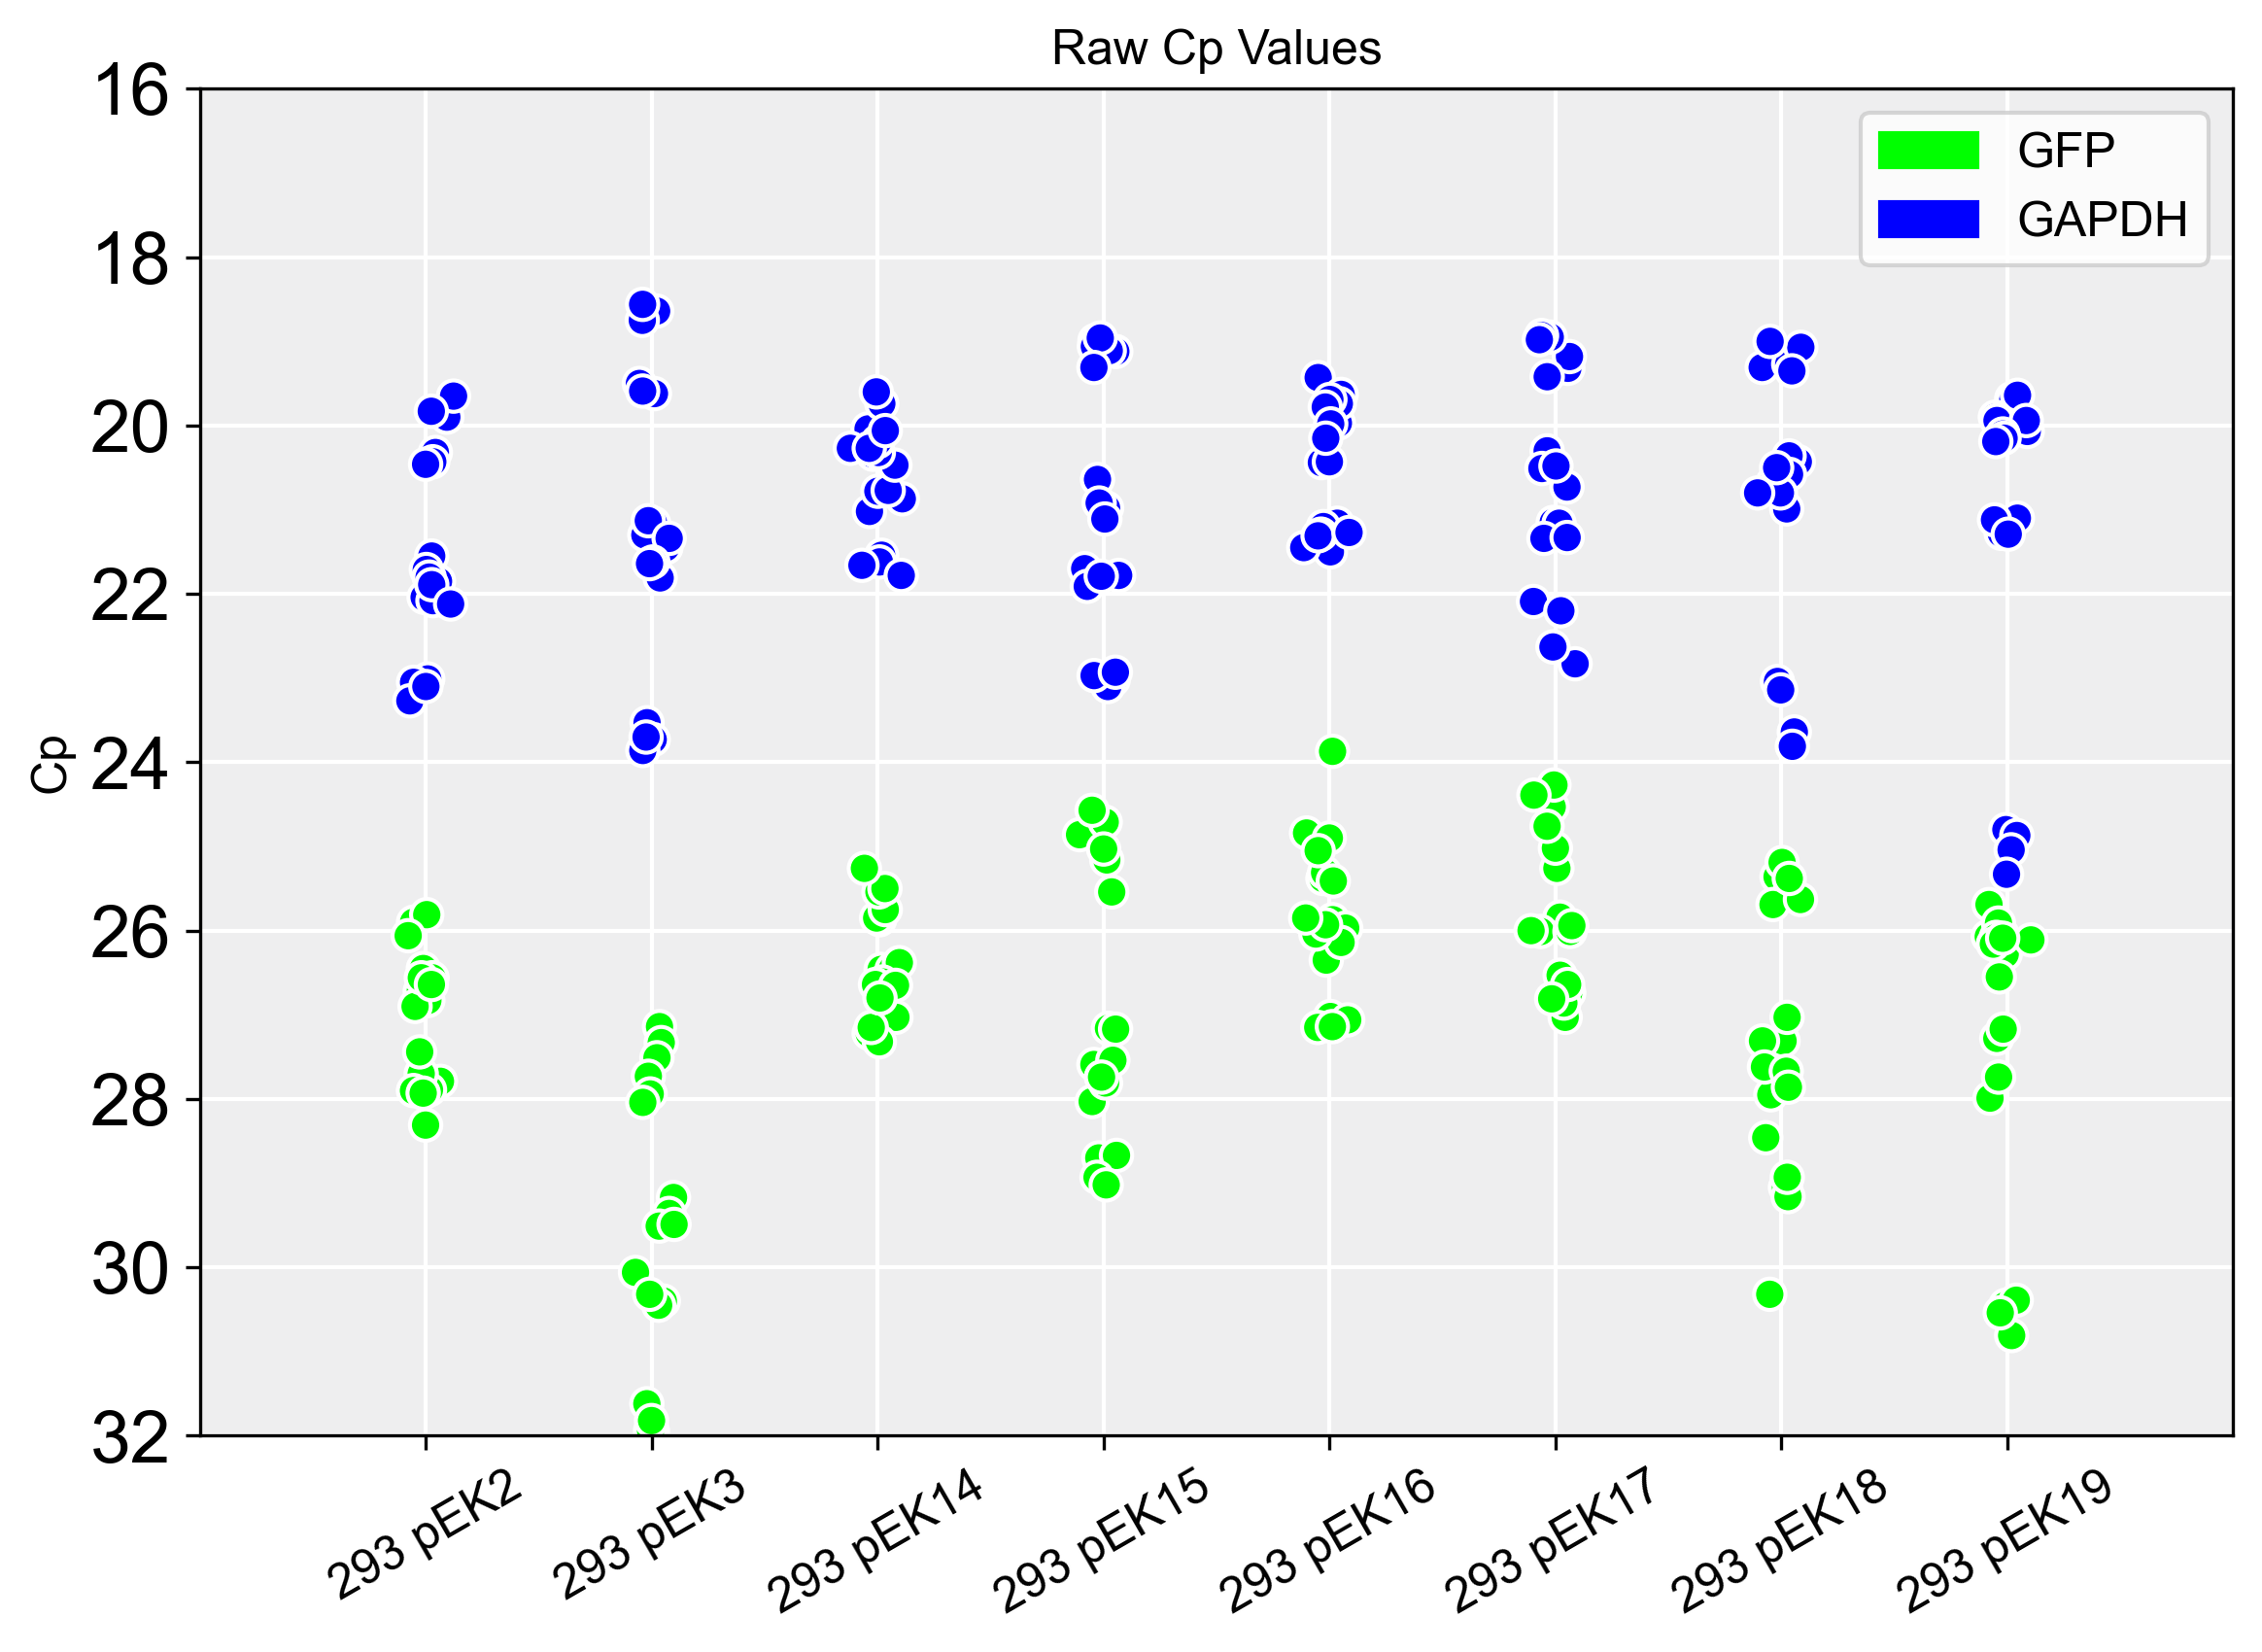

In [7]:
UReps = load_qPCR('EK_HEK-UbC-repeats_proc.csv')

UReps = process_qPCR(UReps)
UReps_samples = list(OrderedDict.fromkeys(UReps.Sample))
UReps_primers = list(OrderedDict.fromkeys(UReps.Primers))

# first scatter raw (i.e. with all 4 tech reps)

CpScatter(UReps,UReps_samples,UReps_primers,colors=['lime','blue'], leg=1)

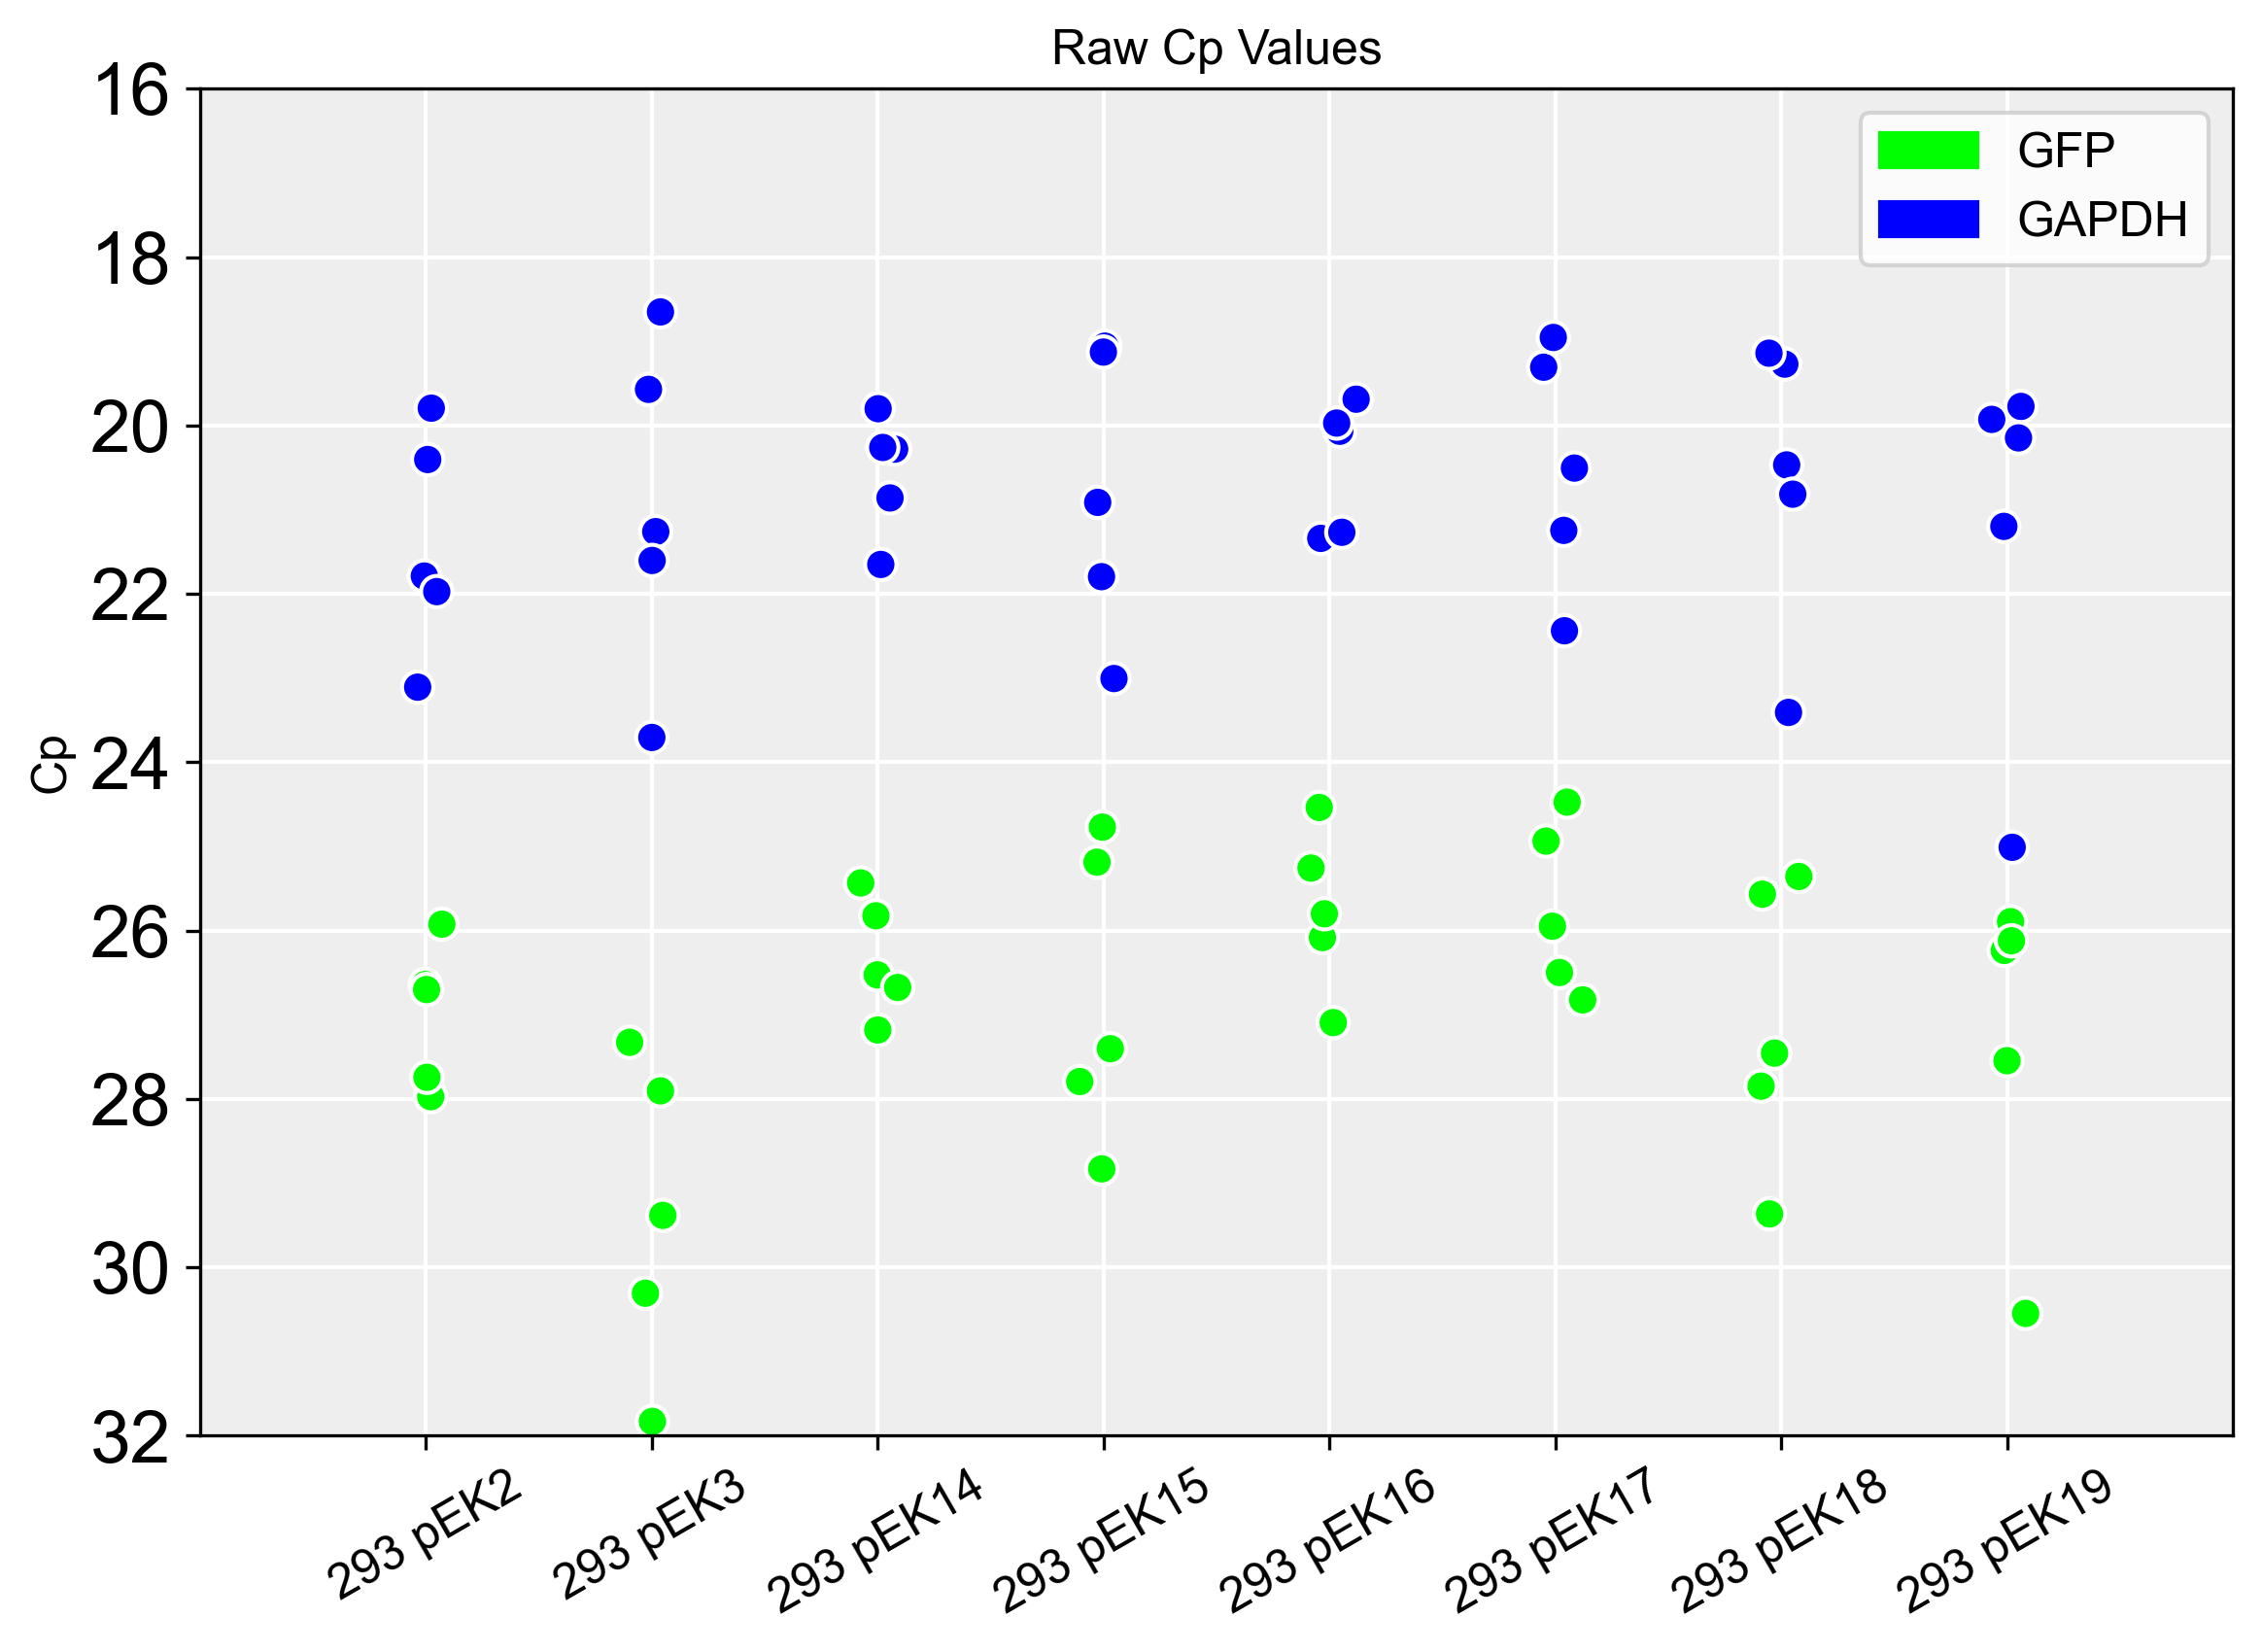

In [8]:
# now with tech reps averaged
UReps = techRepsAvg_proc(UReps,UReps_samples,UReps_primers,5)
CpScatter(UReps,UReps_samples,UReps_primers,colors=['lime','blue'], leg=1)

In [9]:
# calculate fold-changes per intron tested
UReps_introns = list(OrderedDict.fromkeys(UReps.Intron))
UReps_FC = ddCt2(UReps,UReps_samples,UReps_primers,UReps_introns,5,'GAPDH')

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_29061/1294616524.py:273: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  no_int = float(test_no_int)-float(ctrl_no_int)
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_29061/1294616524.py:274: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  w_int = float(test_int)-float(ctrl_int)


In [10]:
# load corresponding FACS data
UReps_F = load_FACS("2019/March 2019","HEK-UbC-repeats-1.txt")
UReps_introns.remove('none')  
UReps_F = dFluor3(UReps_F, UReps_introns)

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_29061/1294616524.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[243.  298.  301.  249.  292.  288.  218.  258.  246.  266.   29.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  FACS['GeoMean'][FACS.Fluor=="dTomato"] = FACS['Geometric Mean (PE-A)']


# alt strategy: import raw data and compute mean and SD

In [11]:
import fcsparser

# function to read fcs data
def fcs_to_list(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['FITC-A'])

# function to read FITC and PE
def fcs_to_list_with_dTom(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['FITC-A']), list(data['PE-A'])

def fcs_to_list_dTom_only(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['PE-A'])

In [12]:
# import data from .fcs files for each sample, store as dict
pilots_repeat_FACS = {}
samples = ['A2','intronless','UbC','EF1a','HBB','rat PPI','TPI']

for sample in samples:
    samppath = f'/Users/emmakowal/Dropbox (MIT)/Lab/FACS/2019/March 2019/HEK-UbC-repeats/{sample}.fcs'
    pilots_repeat_FACS[sample] = list(fcs_to_list(samppath))

In [13]:
for k,v in pilots_repeat_FACS.items():
    print(f'{k:14s}length: {len(v)}\tmean: {np.mean(v)}  \tstd: {np.std(v)}')

A2            length: 25671	mean: 344.48252513433647  	std: 295.5553119291203
intronless    length: 23348	mean: 1622.7224706659501  	std: 1997.8328789510197
UbC           length: 23974	mean: 10678.307666165185  	std: 11115.968938606988
EF1a          length: 24436	mean: 13993.700710282874  	std: 10589.609192795268
HBB           length: 23429	mean: 5846.455891048452  	std: 7713.628043989657
rat PPI       length: 24444	mean: 6925.575066219208  	std: 8428.7899790842
TPI           length: 22773	mean: 7202.653154095553  	std: 7815.77353650541


In [14]:
# subtract background
pilots_repeat_FACS_bg = {}
bg_mean = np.mean(pilots_repeat_FACS['A2'])

for sample in samples[1:]:
    pilots_repeat_FACS_bg[sample] = pilots_repeat_FACS[sample] - bg_mean

for k,v in pilots_repeat_FACS_bg.items():
    print(f'{k:14s}length: {len(v)}\tmean: {np.mean(v)}  \tstd: {np.std(v)}')

intronless    length: 23348	mean: 1278.2399455316138  	std: 1997.8328789510197
UbC           length: 23974	mean: 10333.825141030846  	std: 11115.968938606988
EF1a          length: 24436	mean: 13649.218185148535  	std: 10589.609192795268
HBB           length: 23429	mean: 5501.973365914115  	std: 7713.628043989657
rat PPI       length: 24444	mean: 6581.09254108487  	std: 8428.7899790842
TPI           length: 22773	mean: 6858.170628961215  	std: 7815.7735365054095


In [15]:
# normalize to intronless to get fold-changes
pilots_repeat_FACS_FCs = {}
intless_mean = np.mean(pilots_repeat_FACS_bg['intronless'])

for sample in samples[2:]:
    pilots_repeat_FACS_FCs[sample] = pilots_repeat_FACS_bg[sample] / intless_mean

for k,v in pilots_repeat_FACS_FCs.items():
    print(f'{k:14s}length: {len(v)}\tmean FC: {np.mean(v)}\tstd: {np.std(v)}')

UbC           length: 23974	mean FC: 8.084417309250227	std: 8.696308527569846
EF1a          length: 24436	mean FC: 10.67813459660885	std: 8.284523754568708
HBB           length: 23429	mean FC: 4.304335336372133	std: 6.034569699495345
rat PPI       length: 24444	mean FC: 5.148558034108241	std: 6.594059283273851
TPI           length: 22773	mean FC: 5.365323351797565	std: 6.114480746613553


In [16]:
# do qPCR in same format

pilots_repeat_qPCR_FCs = {}

for sample in samples[2:]:
    pilots_repeat_qPCR_FCs[sample] = list(UReps_FC.FC[(UReps_FC.Primers=='GFP')&(UReps_FC.Intron==sample)])

for k,v in pilots_repeat_qPCR_FCs.items():
    print(f'{k:9s}length: {len(v)}\tmean: {np.mean(v)}   \tstd:{np.std(v)}')

UbC      length: 5	mean: 7.363929332680762   	std:2.151662755083925
EF1a     length: 5	mean: 9.112115251996222   	std:2.3063563710896977
HBB      length: 5	mean: 5.244884963436232   	std:0.7815561703882317
rat PPI  length: 5	mean: 4.02405193151644   	std:1.4025233916025006
TPI      length: 5	mean: 5.168405274055751   	std:1.0806895291586214


# new plot

In [17]:
UbC_pilots_repeat_summary = pd.DataFrame.from_dict({'Intron':samples[2:],
                                                    'meanRNA_FC':[np.mean(pilots_repeat_qPCR_FCs[sample]) for sample in samples[2:]],
                                                    'SDRNA_FC':[np.std(pilots_repeat_qPCR_FCs[sample]) for sample in samples[2:]],
                                                    'SEMRNA_FC':[np.std(pilots_repeat_qPCR_FCs[sample])/np.sqrt(len(pilots_repeat_qPCR_FCs[sample])) for sample in samples[2:]],
                                                    'meanProt_FC':[np.mean(pilots_repeat_FACS_FCs[sample]) for sample in samples[2:]],
                                                    'SDProt_FC':[np.std(pilots_repeat_FACS_FCs[sample]) for sample in samples[2:]],
                                                    'SEMProt_FC':[np.std(pilots_repeat_FACS_FCs[sample])/np.sqrt(len(pilots_repeat_FACS_FCs[sample])) for sample in samples[2:]]})
UbC_pilots_repeat_summary

,Intron,meanRNA_FC,SDRNA_FC,SEMRNA_FC,meanProt_FC,SDProt_FC,SEMProt_FC
0,UbC,7.363929,2.151663,0.962253,8.084417,8.696309,0.056165
1,EF1a,9.112115,2.306356,1.031434,10.678135,8.284524,0.052997
2,HBB,5.244885,0.781556,0.349523,4.304335,6.034570,0.039425
3,rat PPI,4.024052,1.402523,0.627228,5.148558,6.594059,0.042176
4,TPI,5.168405,1.080690,0.483299,5.365323,6.114481,0.040518


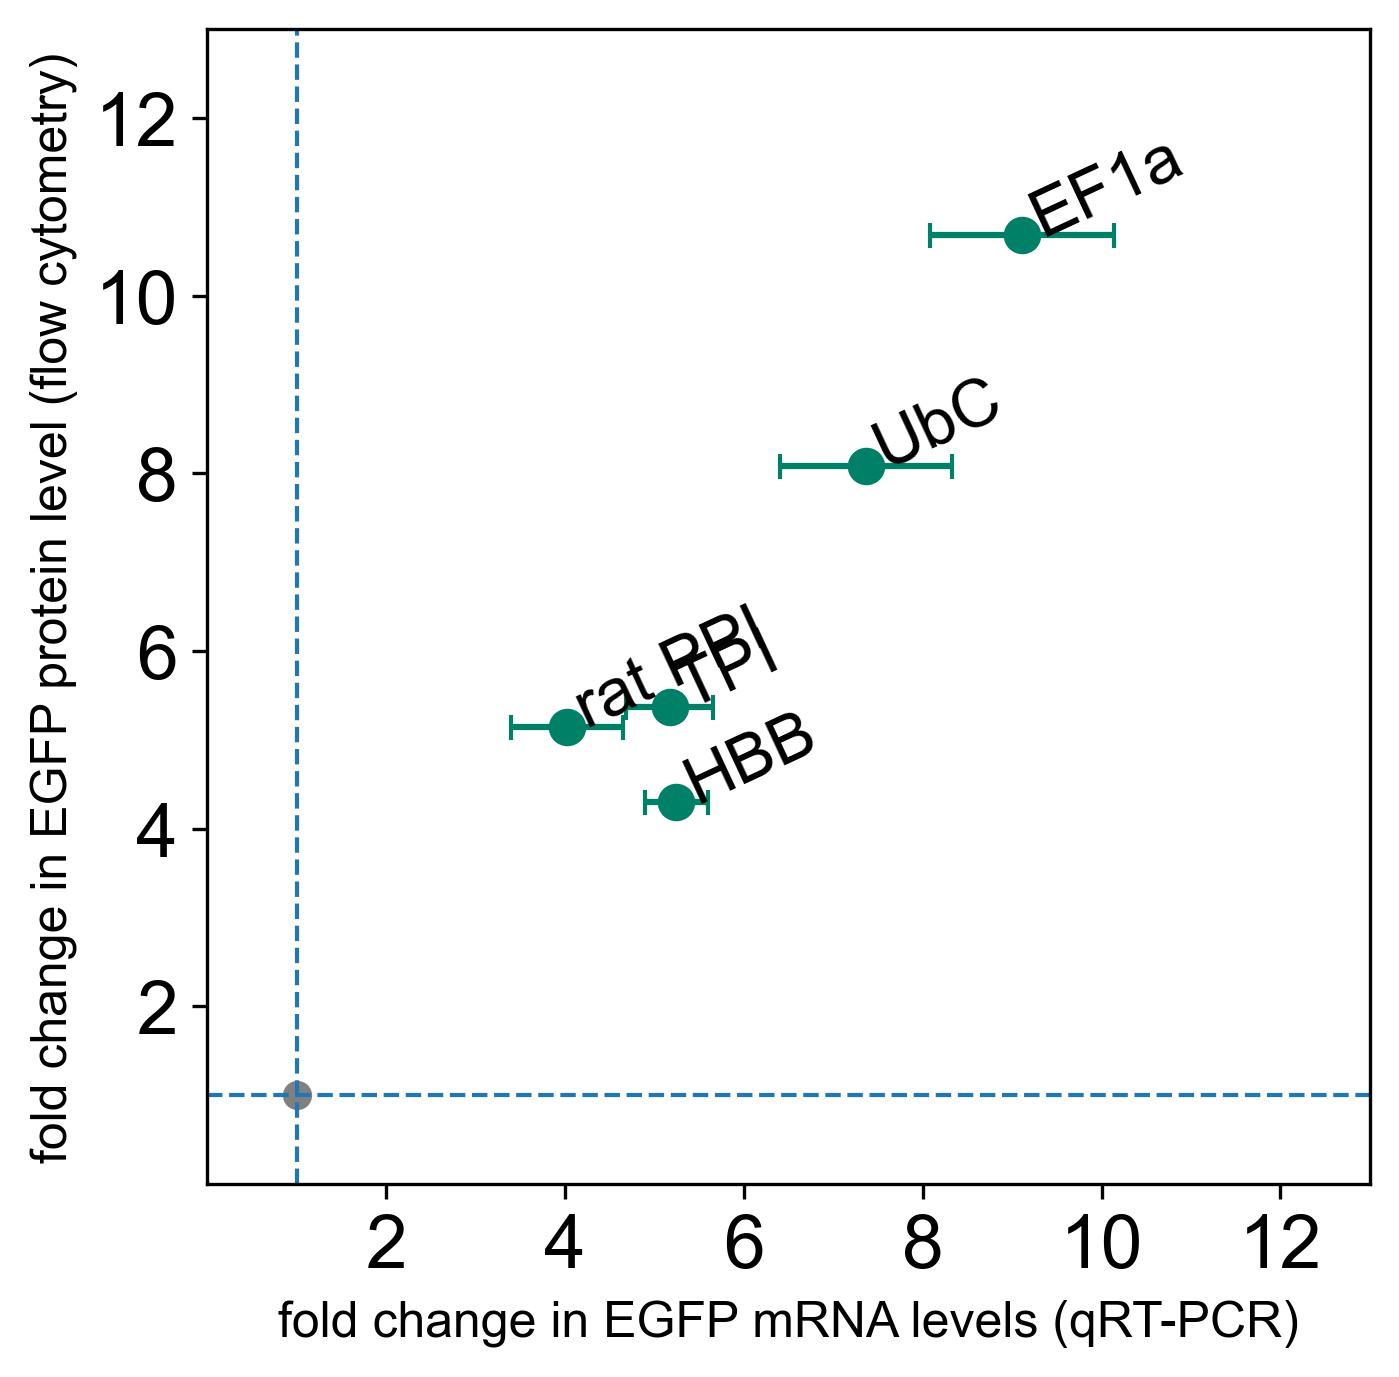

In [18]:
# NEW new plot!!!!!!!11

summergreen = plt.get_cmap('summer')(0)
s=5
plt.figure(figsize=(s,s))
plt.errorbar(UbC_pilots_repeat_summary['meanRNA_FC'],
             UbC_pilots_repeat_summary['meanProt_FC'],
             yerr=UbC_pilots_repeat_summary['SEMProt_FC'],
             xerr=UbC_pilots_repeat_summary['SEMRNA_FC'],
             fmt='o',capsize=3,markersize=8,c=summergreen)
plt.scatter(1,1,c='grey')

plt.ylabel('fold change in EGFP protein level (flow cytometry)', fontsize=12)
plt.xlabel('fold change in EGFP mRNA levels (qRT-PCR)', fontsize=12)
plt.yticks(range(2,13,2))
plt.xticks(range(2,13,2))
plt.axvline(1,ls='--',lw='1')
plt.axhline(1,ls='--',lw='1')

rot = 25
for df in [UbC_pilots_repeat_summary]:
    for i in df.index:
        plt.annotate(df.Intron[i],xy=(df.loc[i,'meanRNA_FC'],
                                      df.loc[i,'meanProt_FC']),rotation=rot,
                    fontsize=16)
#plt.annotate('no intron',xy=(1,1),rotation=rot)

plt.ylim(0,13)
plt.xlim(0,13)
plt.show()

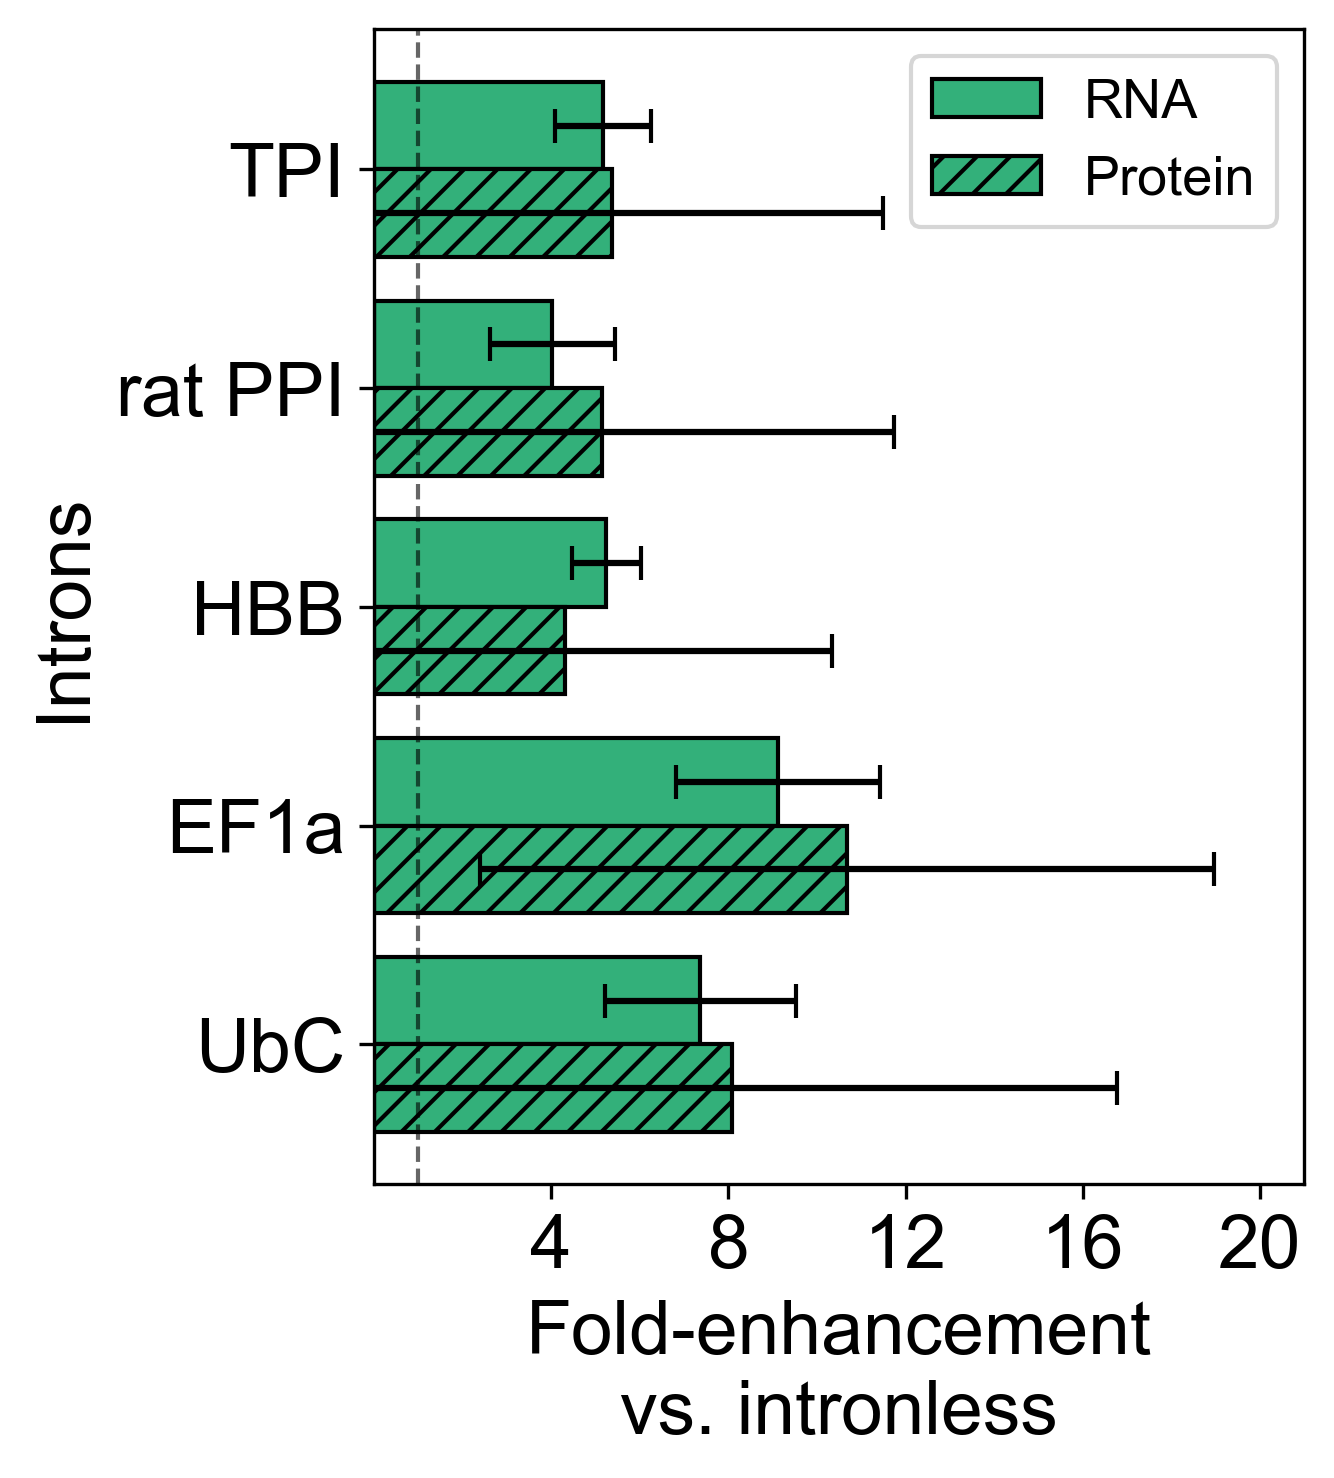

In [19]:
import seaborn as sns
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# Data
introns = UbC_pilots_repeat_summary['Intron']

# Position of bars on X axis
barWidth = 0.4
r1 = np.arange(len(introns))
r2 = [x + barWidth for x in r1]

# Plotting the bars
plt.figure(figsize=(4, 5))

plt.barh(r2, UbC_pilots_repeat_summary['meanRNA_FC'], color=nicecolors(2), 
         height=barWidth, edgecolor='k', ecolor='k', xerr=UbC_pilots_repeat_summary['SDRNA_FC'], capsize=4, label='RNA')
plt.barh(r1, UbC_pilots_repeat_summary['meanProt_FC'], color=nicecolors(2), 
         height=barWidth, edgecolor='k', ecolor='k', xerr=UbC_pilots_repeat_summary['SDProt_FC'], capsize=4, hatch='///', label='Protein')

# Adding xticks
plt.yticks([r + barWidth/2 for r in range(len(introns))], introns)
plt.xticks(np.arange(0,22,2))
plt.xticks([4,8,12,16,20])
plt.xlim(0,21)

plt.axvline(1,linestyle='--',linewidth=1,color='k', alpha=0.6)

# Add labels
plt.xlabel('Fold-enhancement\nvs. intronless')
plt.ylabel('Introns')
#plt.title('Protein and RNA Fold-Enhancement for Each Intron')
plt.legend(bbox_to_anchor=(1,1), fontsize=13)

# Show plot
plt.show()


In [20]:
UbC_pilots_repeat_summary.loc[-1] = ['no intron',1,0,0,1,0,0]
UbC_pilots_repeat_summary.index = UbC_pilots_repeat_summary.index + 1  # shifting index
UbC_pilots_repeat_summary = UbC_pilots_repeat_summary.sort_index(ascending=False)

In [21]:
UbC_pilots_repeat_summary.sort_values('meanProt_FC', inplace=True, ascending=False)

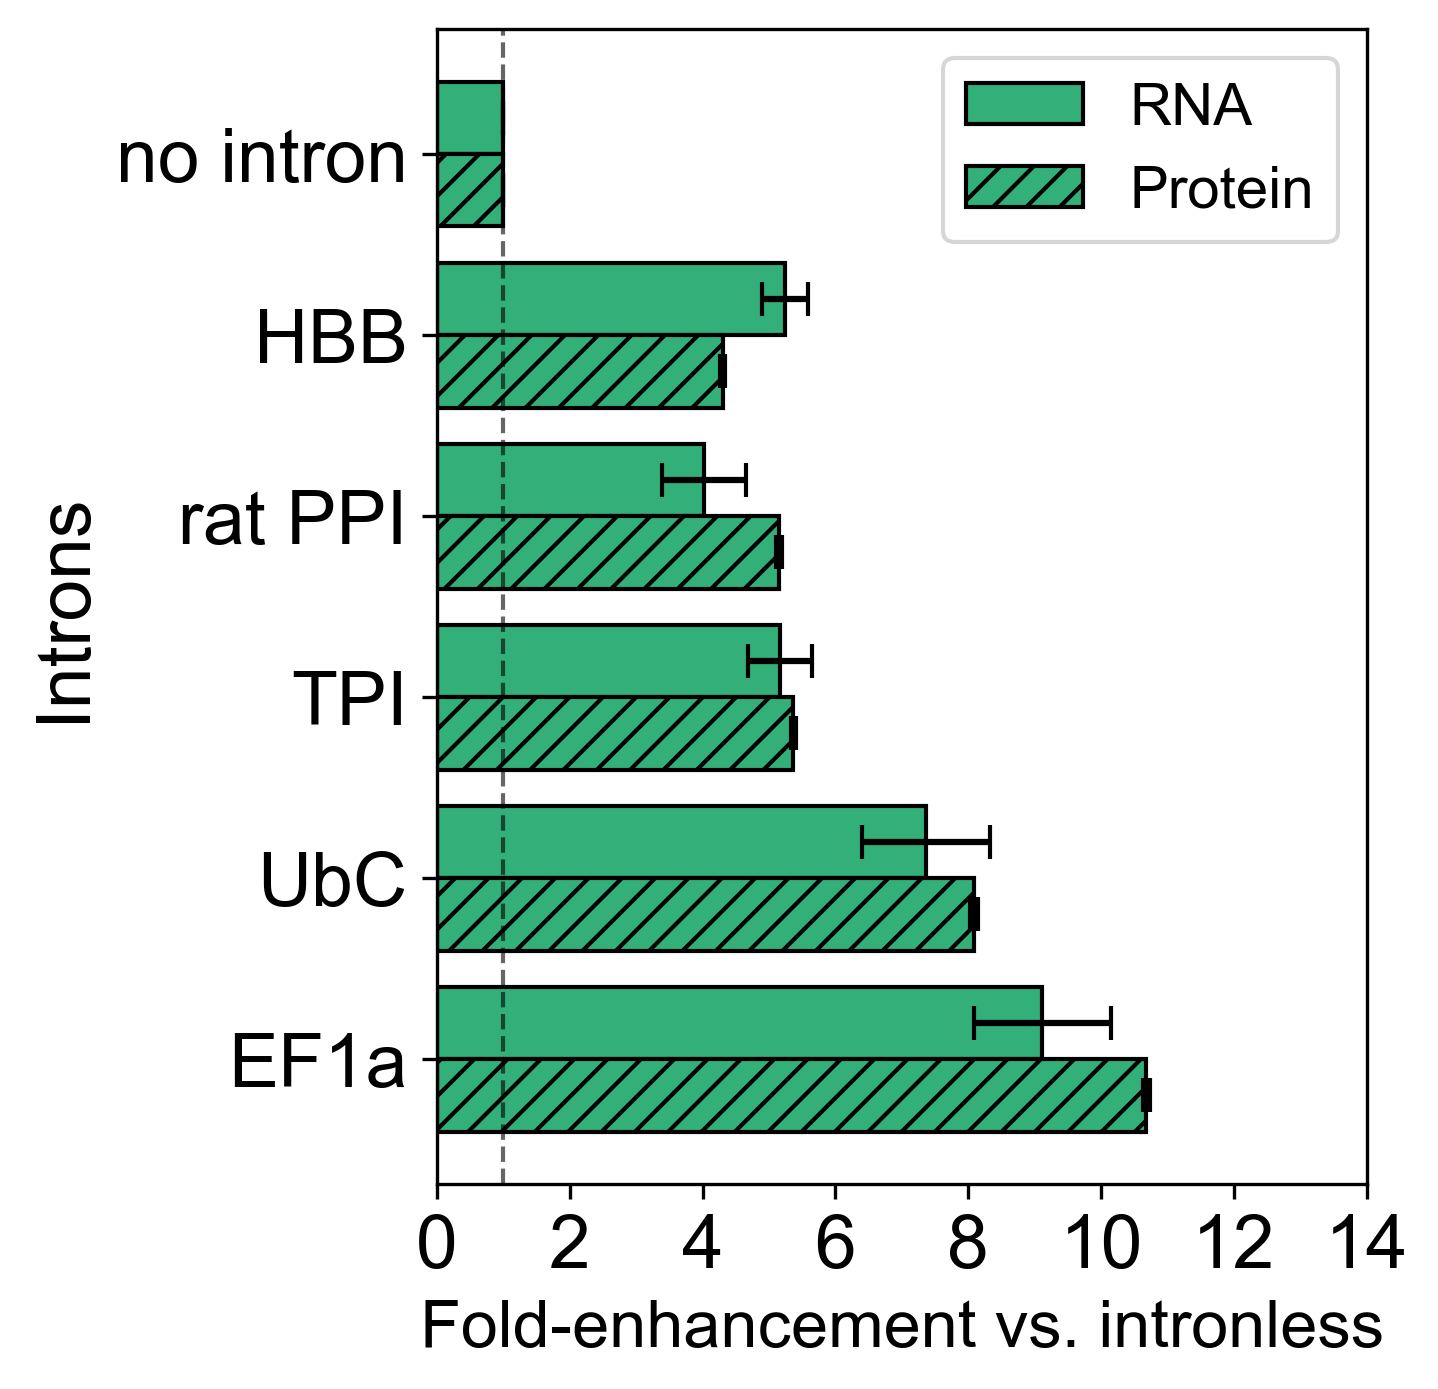

In [26]:
import seaborn as sns
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# Data
introns = UbC_pilots_repeat_summary['Intron']

# Position of bars on X axis
barWidth = 0.4
r1 = np.arange(len(introns))
r2 = [x + barWidth for x in r1]

# Plotting the bars
plt.figure(figsize=(4, 5))

plt.barh(r2, UbC_pilots_repeat_summary['meanRNA_FC'], color=nicecolors(2), 
         height=barWidth, edgecolor='k', ecolor='k', xerr=UbC_pilots_repeat_summary['SEMRNA_FC'], capsize=4, label='RNA')
plt.barh(r1, UbC_pilots_repeat_summary['meanProt_FC'], color=nicecolors(2), 
         height=barWidth, edgecolor='k', ecolor='k', xerr=UbC_pilots_repeat_summary['SEMProt_FC'], capsize=4, hatch='///', label='Protein')

# Adding xticks
plt.yticks([r + barWidth/2 for r in range(len(introns))], introns)
plt.xticks(np.arange(0,16,2))
#plt.xticks([4,8,12,16,20])
#plt.xlim(0,21)

plt.axvline(1,linestyle='--',linewidth=1,color='k', alpha=0.6)

# Add labels
plt.xlabel('Fold-enhancement vs. intronless', fontsize=16)
plt.ylabel('Introns')
#plt.title('Protein and RNA Fold-Enhancement for Each Intron')
plt.legend(bbox_to_anchor=(1,1), fontsize=14)

plt.savefig('figures/Fig1D.png', dpi=900, bbox_inches='tight')

# Show plot
plt.show()
